# TASK A: Image Retrieval with Pre-Trained Image Classification Model

In [1]:
import os
import cv2
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import torchvision.transforms as transforms

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm import tqdm

Initialize Image DataLoader 

In [2]:
DATASET = '../MIT_split'
BATCH_SIZE = 1

# Dataset Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Folders
train_dataset = torchvision.datasets.ImageFolder(os.path.join(DATASET,'train'), transform=transform)
test_dataset = torchvision.datasets.ImageFolder(os.path.join(DATASET,'test'), transform=transform)

# Paths 
train_images = [path for path, label in train_dataset.imgs]
test_images = [path for path, label in test_dataset.imgs]

# Load Images
train_images = np.array([cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in tqdm(train_images)])
test_images = np.array([cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in tqdm(test_images)])

# Images shape
print(f"Train Images : {train_images.shape}")
print(f"Test Images : {test_images.shape}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 807/807 [00:02<00:00, 339.70it/s]


Train Images : (1881, 256, 256, 3)
Test Images : (807, 256, 256, 3)


### Retrieval with KNN

First we load the data, apply some normalization and apply dim. reduction.

In [9]:
# Load Saved Features
train_features = pkl.load(open("./features/train_features_resnet50.pkl", "rb"))
test_features = pkl.load(open("./features/test_features_resnet50.pkl", "rb"))
# Flatten List
train_features = np.array([item for sublist in train_features for item in sublist]).reshape((1881, 2048))
test_features = np.array([item for sublist in test_features for item in sublist]).reshape((807, 2048))

# Normalize
normalizer = StandardScaler() # Normalize Data
train_features = normalizer.fit_transform(train_features)
test_features = normalizer.transform(test_features)

# Dim Before Reduction
print(f"Train Dim Before Reduction : {train_features.shape}")
print(f"Test Dim Before Reduction : {test_features.shape}")

# Dim Reduction
pca = PCA(n_components=0.95) # Keep 95% Variance
train_features = pca.fit_transform (train_features)
test_features = pca.transform (test_features)

print("---"*15)

# Dim After Reduction
print(f"Train Dim After Reduction : {train_features.shape}")
print(f"Test Dim After Reduction : {test_features.shape}")


Train Dim Before Reduction : (1881, 2048)
Test Dim Before Reduction : (807, 2048)
---------------------------------------------
Train Dim After Reduction : (1881, 372)
Test Dim After Reduction : (807, 372)


Then we train a NearestNeighbor to get similar images

In [23]:
if not os.path.exists("./models/knn_model.pkl"):
    model = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(train_features)
    pkl.dump(model, open("./models/knn_model.pkl", "wb"))
else:
    model = pkl.load(open("./models/knn_model.pkl", "rb"))

In [24]:
def retrieve_top_k(model, query):
    distances,indices = model.kneighbors(query.reshape((1, train_features.shape[1])))
    top = [train_images[indices[0][0]], train_images[indices[0][1]], train_images[indices[0][2]]]
    return top

# Plot top K and query
def plot_top_k(query, top):
    fig, axs = plt.subplots(2, 2, figsize=(15,15))
    axs[0, 0].imshow(query)
    axs[0, 0].set_title('Query Image')
    axs[0, 0].axis('off')
    axs[0, 1].imshow(top[0])
    axs[0, 1].set_title('Top 1')
    axs[0, 1].axis('off')
    axs[1, 0].imshow(top[1])
    axs[1, 0].set_title('Top 2')
    axs[1, 0].axis('off')
    axs[1, 1].imshow(top[2])
    axs[1, 1].set_title('Top 3')
    axs[1, 1].axis('off')
    plt.axis("off")
    plt.show()

Evaluating with Train Data

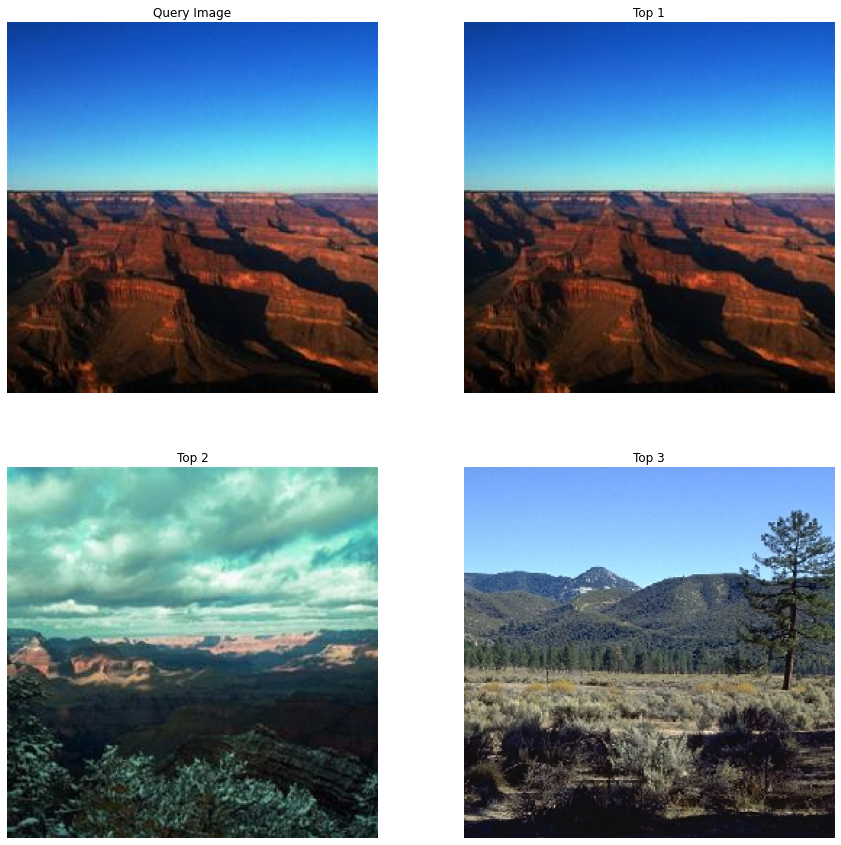

In [25]:
top = retrieve_top_k(model = model, query = train_features[5])
plot_top_k(train_images[5], top)

Evaluating with Test Data

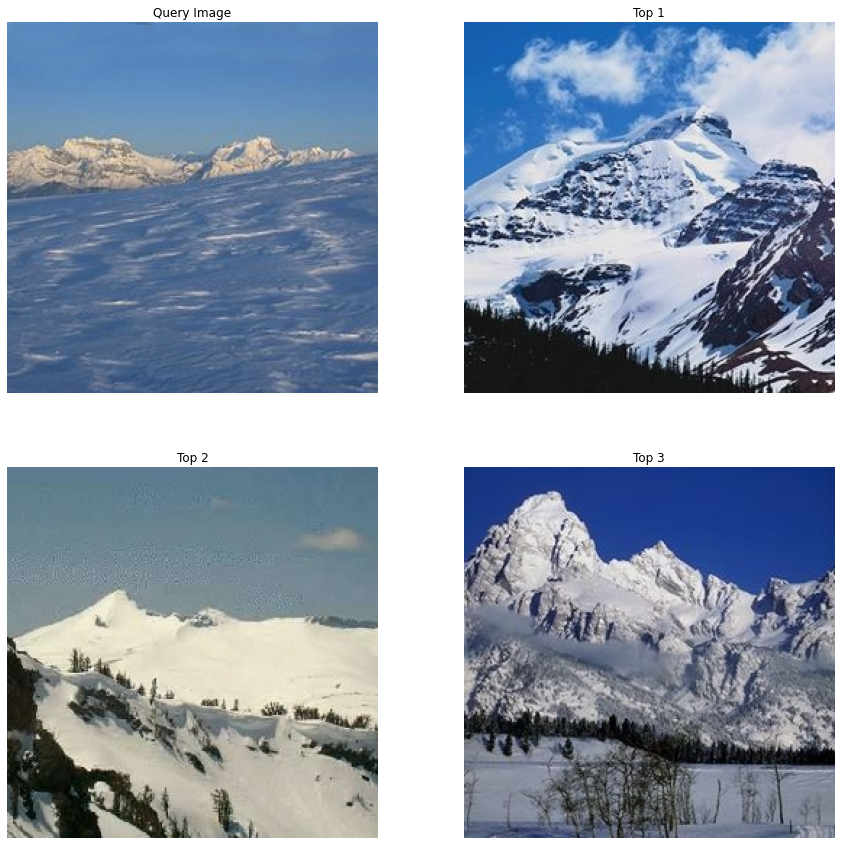

In [26]:
top = retrieve_top_k(model = model, query = test_features[18])
plot_top_k(test_images[18], top)